In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torchvision
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms

### MLP on Large Data set with PyTorch

Let's create a NN on a bigger data set. We will use MNIST Digit set. This time we will upload a set containing 60000 digits of oh higher quality than before. We will use PyTorch to do so. We will also preprocess our data. We will use `transforms`, which is a way to create Pipelines with PyTorch. I want to convert every image into Tensor and then Normalize the values so that they are smaller. We can apply these transforms directly the moment we upload our data sets.

Finally, we will move most computation to GPU instead of CPU if it is available. This is done by setting device to 'cuda'. Then, moving our model and batches to the device. Note, NumPy doesn't support GPU yet, so if we need to apply NumPy to our tensors, we would move to CPU. 

If you dont want to use GPU, you can either set `device='cpu'` or remove all `.to(device)` and not set device to anything.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),    # mean and std
                              ])

In [21]:
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [22]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [23]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Let's look at the single batch.

In [24]:
dataiter = iter(trainloader)
images, labels = next(dataiter)


print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


As you can see, a single batch is a 4-dim array:
1. 64 is the amount of images in the single batch
2. 1 is a color channel. Since our images are greyscale we have only one chanel. This dim is useless to us. Technically, we could have applied transform to get rid of it. Note, if our image is a color image, this will usually have 3 values (RGB).
3. 28, 28 is the size of a single image. It is 28 by 28 pixels.

Let's see what a the first inmage looks like. (`squeeze` gets rid of singular dimension)

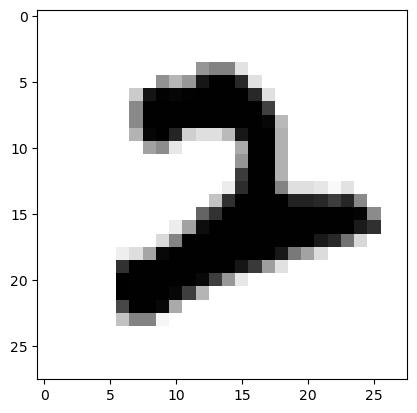

In [25]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

And here are few more examples:

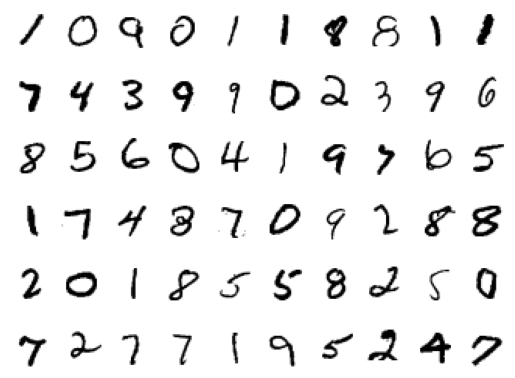

In [26]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Let's create our NN. This time I will use 2 hidden layers. I will also add `nn.Sequential` to avoid retyping our functions in the forward method. Lastly, I will use `flatten` to convert 28 by 28 array into a single dimension vector of size 28*28 = 784

In [27]:
input_size = 784     # 28*28
hidden_sizes = [128, 64] #two hidden layers
output_size = 10


class DigitMLP(nn.Module):
    
    def __init__(self):
        super(DigitMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



In [28]:
model = DigitMLP().to(device)
print(model)

n_epochs=3
lr=0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum =0.9)


DigitMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


Instead of using CrossEntropyLoss we could have used NLLLoss, but then we would have to add Softmax as last activation function

In [29]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]
predictions = []
y_true = []

In [30]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        data = data.reshape(-1, 28*28)

        data=data.to(device)
        target=target.to(device)
        
        output = model(data)
        
        

        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                                                                           batch_idx * len(data), 
                                                                           len(trainloader.dataset),
                                                                           100. * batch_idx / len(trainloader), 
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))

In [31]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for data, target in testloader:
            data = data.reshape(-1, 28*28)

            data=data.to(device)
            target=target.to(device)
            
            output = model(data)
            
            
            test_loss += loss_func(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(testloader)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                              correct, 
                                                                              len(testloader.dataset),100. * correct / len(testloader.dataset)))

In [32]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3115, Accuracy: 905/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288428
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.600291
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.454991
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.199812
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.429852
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.307769
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.268648
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.556066
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.401765
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.225801

Test set: Avg. loss: 0.2073, Accuracy: 9366/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.311901
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.233892
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.051773
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.219850
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.174222
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.261380
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.054230
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.08393

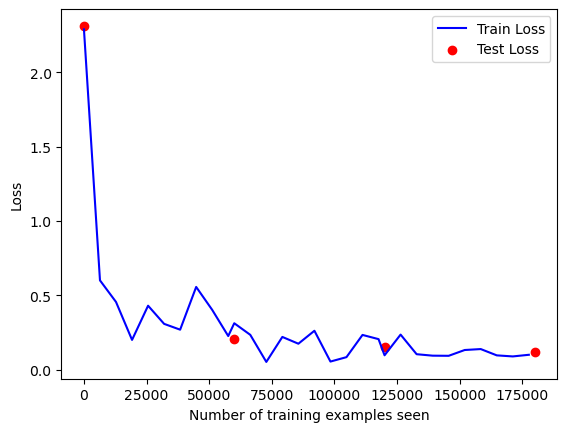

In [33]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('Loss')
plt.show()

In [34]:
predictions = []
y_true = []

# iterate over test data
for inputs, labels in testloader:

        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).detach().cpu().numpy()
        predictions.extend(output) # Save Prediction
        
        labels = labels.cpu().data.numpy()
        y_true.extend(labels) # Save Truth


print('Confusion Matrix = \n',confusion_matrix(y_true, predictions))

Confusion Matrix = 
 [[ 965    0    0    1    1    3    6    2    2    0]
 [   0 1122    3    1    0    1    3    0    5    0]
 [  11    2  990    1    5    0   13    6    4    0]
 [   1    0    8  956    0   20    0   12   10    3]
 [   2    0    2    0  960    0    8    1    2    7]
 [   5    2    0    2    3  853   15    1    7    4]
 [   6    2    0    1    3    2  941    0    3    0]
 [   1   12   11    0    0    0    1  992    1   10]
 [   5    1    2    4    3    7   11    8  933    0]
 [   7    7    1    5   37    7    1   11    2  931]]


### How do we choose amount of layers and amount of nodes in each layer?

For input and output layer the this is easy, there is only one choice. However for hidden layers this is not an easy question and highly depends on many factors. Clearly, the more layers and more nodes we have the more computationally expensive model will be. Another thing to keep in mind is that the more layers we have, more likely we will get Vanishing Gradient Problem. So, for very deep networks, we should apply more spcialized algorithms. However, for most problems we don't need very deep networks:

1. If your data is linearly separable, then you actually dont need any hidden layers. You dont really need NN at all here.
2. A single hidden layer can solve most problems.
3. Problems that require two hidden layers are more rare, but we can create almost any desision boundary with it.
4. Generally, the more features you have, the more layers you will probably want. Hidden layers in deep NN are generally more complex than just a linear layers we discussed so far. Problems that often use deep NN:
       a. Image or video recognision problems will use deeper NN (CNN);
       b. Language processing (translation, text generation, etc) will use deep NN (RNN, Transformers)
       c. Time series forecasting often use deed NN (LSTM)
       d. Speech Recognition use deep CNN and/or RNN.
5. Adding more layers may lead to overfit, so more is not always better.

How about number of nodes in each hidden layer? Again there is no single answers to this, but keep the following note in mind:

1. Too many nodes can lead to overfit.
2. Generally, you want number of nodes in the hidden layer to be between number of nodes in the input layer and the output layer.

Other thigns that we can manipulate to improve our NN model:

1. Learning rate
2. Momentum (when we do SGD and you gradinet is small, the convergence slows down dramatically. Momentum let's you use previous gradients. It speeds up the convergence.
3. We can apply early stopping to avoid overfiting and improve performance
4. We can use other optimizers besides SGD ( such as Adam, Adagrad, AdaDelta, Nadam, Adamax, etc)

We will talk about momentum and optimizers in the future.

In [22]:
torch.save(model.state_dict(), '.\DigitMLPExample.pth')

Let's draw a picture and see if our model can guess the digit (The digit should be white on black background, and saved as Digit.png).

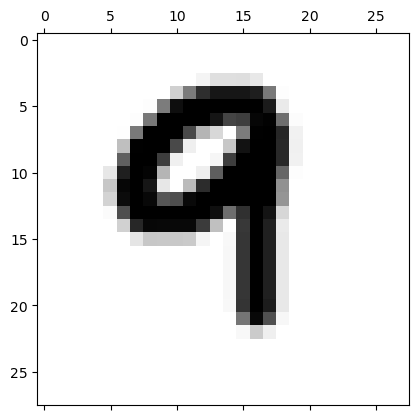

In [35]:
from PIL import Image

image = Image.open('Digit.png')
img = image.convert('L')    # converts it to greyscale
img = img.resize((28,28))
img = np.asarray(img)

plt.matshow(img, cmap = 'gray_r')
plt.show()

In [36]:
imgtensor = transform(np.array(img)).to(device)
with torch.inference_mode():
    
    output = model(imgtensor)
    guess=(torch.max(torch.exp(output), 1)[1])[0]
    perc=torch.max(torch.exp(output)/torch.exp(output).sum())*100
    print(f'This is {guess}, and I am {perc:.1f}% confident about this')

This is 9, and I am 91.0% confident about this


Overall out guess were good, but for image recognition, we should be using a different type of Neural Network called Convolutional Neural Network (CNN), which we will look at next time.